In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
import tensorflow.keras.applications.imagenet_utils as iu
from tensorflow.keras.preprocessing.image import load_img, img_to_array,array_to_img,save_img
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from tensorflow.keras.models import Sequential,load_model
import cv2


to shuffle the array in unison


In [ ]:
def shuffle_in_unison_scary(a,b,c):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    np.random.set_state(rng_state)
    np.random.shuffle(c)

load model and helper functions

In [ ]:
model=load_model('/content/gdrive/My Drive/models/sp_model_15_softmax2.h5')

#function to preprocess image   
def preprocess_img(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(image)
    image = image[None, ...]
    
    return image

#for reverse pre-process
def restore_original_image_from_array(x, data_format='channels_last'):
    mean = [103.939, 116.779, 123.68]

    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if x.ndim == 3:
            x[0, :, :] += mean[0]
            x[1, :, :] += mean[1]
            x[2, :, :] += mean[2]
        else:
            x[:, 0, :, :] += mean[0]
            x[:, 1, :, :] += mean[1]
            x[:, 2, :, :] += mean[2]
    else:
        x[..., 0] += mean[0]
        x[..., 1] += mean[1]
        x[..., 2] += mean[2]

    if data_format == 'channels_first':
        # 'BGR'->'RGB'
        if x.ndim == 3:
            x = x[::-1, ...]
        else:
            x = x[:, ::-1, ...]
    else:
        # 'BGR'->'RGB'
        x = x[..., ::-1]

    return x



def reverse_preprocess(p_img,a_numpy=True):
    if a_numpy:
      p_img=p_img.numpy()
    ip_img=restore_original_image_from_array(p_img, data_format='channels_last')
    ia_img=array_to_img(ip_img[0])
    img=ia_img
    return img

#helper function to display images
def l_display_images(model,image,description,savepath=None,save=False,single_img=True,categorical=True):

    classes={0:'Unaffected',1:'DR Affected'}
    i=0
    if (single_img==False):
      for img in image:
        preds=model.predict(img)
        if categorical:
            label=np.argmax(preds)
            class_confidence=preds[i][label]
        else:
            label = (preds > 0.5).reshape(1).astype(np.int)[0]
            class_confidence=preds.reshape(1).astype(np.float32)[0]
        
        print(label)
        image_class=classes[label]
      
        print("result",label,image_class, class_confidence)

        img=reverse_preprocess(img)
        plt.figure()
        plt.imshow(img)
        plt.title('{} \n {} : {:.2f}%'.format(description,
                                                        image_class,class_confidence*100))
        plt.show()
        if save:
          path=savepath+'img{}'.format(i)
          save_img(path)
        i=i+1
        print('completed')
    else:

      preds=model.predict(image)
      if categorical:
          label=np.argmax(preds)
          class_confidence=preds[0][label]
      else:
          label = (preds > 0.5).reshape(1).astype(np.int)[0]
          class_confidence=preds.reshape(1).astype(np.float32)[0]
        
      print(label)
      image_class=classes[label]
      print("result",preds,image_class, class_confidence)

      img=reverse_preprocess(image)
      plt.figure()
      plt.imshow(img)
      plt.title('{} \n {} : {:.2f}%'.format(description,
                                                      image_class,class_confidence*100))
      plt.show()
      if save:
        path=savepath+'img{}'.format(i)
        save_img(path)



Test data

In [ ]:
with np.load('/content/gdrive/My Drive/models/sp_test_conf.npz') as data:
    dataset = data["dataset"]
    labels = data["labels"]
    conf=data['conf']


shuffle_in_unison_scary(dataset,labels,conf)

In [ ]:
x=dataset[:100]
y=labels[:100]
confidence=conf[:100]
x=np.asarray(x)
y=np.asarray(y)
confidence=np.asarray(confidence)
print(x.shape,y.shape,confidence.shape)

(100, 224, 224, 3) (100,) (100,)


In [ ]:
t_labels=np.zeros(y.shape)
for i in range(100):
    t=1-y[i]
    t_labels[i]=t

In [ ]:
p_img=np.zeros(x.shape)
for i in range(100):
  p_img[i]=preprocess_img(x[i])

#p_img=tf.convert_to_tensor(p_img)
p_img=tf.cast(p_img,dtype=tf.float32)
print(p_img.dtype)

<dtype: 'float32'>


Single image case,load sample images

(1, 224, 224, 3)
0
result [[0.81681    0.18318993]] Unaffected 0.81681


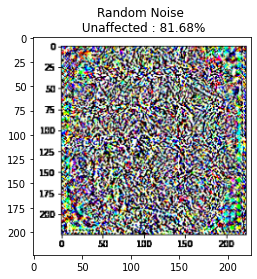

(1, 2)
()


In [ ]:
  
img = load_img('noise_1.png', color_mode="rgb")
a_img = img_to_array(img)

#to test with random noise input
random_img=np.random.randint(50,size=a_img.shape,dtype=np.int32)

p_img = preprocess_img(a_img)
print(p_img.shape)

#display_images(model,img,"Original")
l_display_images(model,p_img,"Random Noise",savepath="",save=False,single_img=True)
print((model(p_img).shape))
preds=model(p_img)
label=np.argmax(preds)
print(label.shape)





[[0.4458306  0.55416936]] [1]
[55.416935]
1
result [[0.4458306  0.55416936]] DR Affected 0.55416936


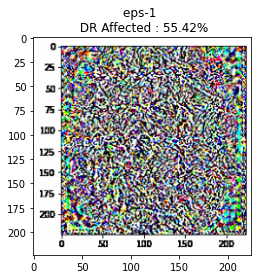

0
result [[0.5089353 0.4910647]] Unaffected 0.5089353


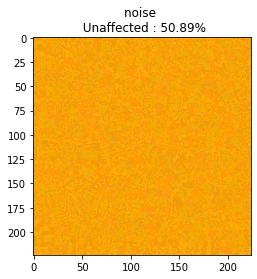

tf.Tensor([73758.35], shape=(1,), dtype=float32)


In [ ]:
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy()
eps=0.7
t_lables=np.array([[1]])
adv_x,noise,norm,conf,f_label=fast_gradient_method(model,p_img,eps,np.inf,clip_min=-1,clip_max=1,y=t_lables,targeted=True,loss_fn=loss_fn)
l_display_images(model,adv_x,'eps-1')
l_display_images(model,noise,'noise')
print(norm)

to check by combining an original image with the perturbed noise

tf.Tensor([[0.04506703 0.954933  ]], shape=(1, 2), dtype=float32)
1
result [[0.04506703 0.954933  ]] DR Affected 0.954933


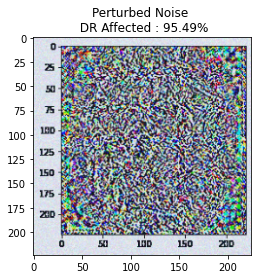

In [ ]:
preds=model(p_img+p_img1)
print(preds)
l_display_images(model,p_img+p_img1,'Perturbed Noise')

Calling FGSM in loop


In [ ]:
#t_lable=np.array([[1,0]])
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy()

attack_imgs=[]
norms=[]
confs=[]
f_labels=[]
for i in range(100):
  adv_x,noise,norm,conf,f_label=fast_gradient_method(model,p_img[i:i+1],0.25,np.inf,clip_min=-1,clip_max=1,y=t_labels[i:i+1],targeted=True,loss_fn=loss_fn)
  attack_imgs.append(adv_x)
  norms.append(norm)
  confs.append(conf)
  f_labels.append(f_label)



#adv_x=p_img+noise
#l_display_images(model,adv_x,"Epsilon:0.7",save=False,savepath="",single_img=True)
#plt.imshow(noise[0])
#print(model(adv_x))
#plt.imshow(adv_x[0])
#plt.show()

[[0.88847953 0.11152051]] [0]
[88.84795]
[[0.10242884 0.8975712 ]] [1]
[89.75712]
[[0.202268 0.797732]] [1]
[79.7732]
[[0.8589151  0.14108485]] [0]
[85.89151]
[[0.6108354 0.3891646]] [0]
[61.083538]
[[0.56430304 0.43569696]] [0]
[56.430305]
[[0.8818057  0.11819433]] [0]
[88.18057]
[[0.2545869  0.74541306]] [1]
[74.541306]
[[0.84554476 0.15445523]] [0]
[84.554474]
[[0.08228765 0.9177124 ]] [1]
[91.77124]
[[0.11235169 0.8876483 ]] [1]
[88.76483]
[[0.03838221 0.96161777]] [1]
[96.16177]
[[0.18767224 0.81232774]] [1]
[81.23277]
[[0.5503432  0.44965675]] [0]
[55.03432]
[[0.10086936 0.8991306 ]] [1]
[89.913055]
[[0.04306754 0.9569325 ]] [1]
[95.693245]
[[0.26417258 0.73582745]] [1]
[73.58275]
[[0.16923705 0.8307629 ]] [1]
[83.076294]
[[0.97399265 0.0260074 ]] [0]
[97.39926]
[[0.6325494  0.36745062]] [0]
[63.25494]
[[0.935265 0.064735]] [0]
[93.5265]
[[0.16587315 0.8341268 ]] [1]
[83.412674]
[[0.8106616  0.18933837]] [0]
[81.06616]
[[0.23468404 0.76531595]] [1]
[76.53159]
[[0.7516605  0.24833

In [ ]:
print(len(confs))
c=0
ind=[]
for i in range(100):
  if (f_labels[i]==t_labels[i]):
    c=c+1
  else:
    #print(i)
    ind.append(i)
print(c)

100
95


In [ ]:
d=0
for i in range(100):
  if (confs[i]>confidence[i] and f_labels[i]==t_labels[i]):
    d=d+1
print(d)

71


In [ ]:
conf_avg=np.average(confs)
conf_max=np.max(confs)
norm_avg=np.average(norms)
norm_max=np.max(norms)
print(conf_avg,conf_max,norm_avg,norm_max)

84.08858 99.731606 9407.997 9408.0


Class variant(tried to create a class,should be improved,use the following variant)

0
result [[1.0000000e+00 3.4923797e-23]] Unaffected 1.0


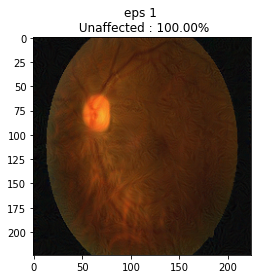

In [ ]:
fgsm_attacker=FGSM_attack(model,p_img,eps=0.7,norm=np.inf,clip_min=-1,clip_max=1,y=t_lable,targeted=True,loss_fn=loss_fn,iterative=True,iters=10)

adv_x,perturbation=fgsm_attacker.attack(p_img)

l_display_images(model,adv_x,"eps 1")

FGSM attack

In [ ]:
def fast_gradient_method(
    model_fn,
    x,
    eps,
    norm,
    loss_fn=None,
    clip_min=None,
    clip_max=None,
    y=None,
    targeted=False,
    iterative=False,
    sanity_checks=False,
):

    if y is None:
        y=np.argmax(model(x))

    if loss_fn is None:
      loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

    if iterative:#if iterative, give also iters
      adv_X,optimal_perturbation=iterative_fgsm(model_fn,x,y,targeted,iters)

    
    #cast if numpy array is given
    x = tf.cast(x, tf.float32)

    #function to compute gradients
    grad = compute_gradient(model_fn, loss_fn, x, y, targeted,iters=1)
    
    #function to find optimal perturbation based on norm
    optimal_perturbation=norm_constraint(grad,eps,norm)
    #adv image created
    adv_x=x+optimal_perturbation

    norm=l2(adv_x,x)
      
    preds=model.predict(adv_x)
    lables=np.argmax(preds,axis=1)
    print(preds,lables)
      
    confidence=np.max(preds,axis=1)*100
    print(confidence)


    return adv_x,optimal_perturbation,norm,confidence,lables


function to compute gradient

In [ ]:
def compute_gradient(model,loss_fn,x,y,targeted,iters):
    for epoch in range(iters):
      with tf.GradientTape() as gt:
        gt.watch(x)
        label=model(x)
        loss=loss_fn(y,label)
        #print(loss)
        if(targeted):
          loss=-loss

    grad=gt.gradient(loss,x)
    #print(grad)
    return grad


function to apply norm constraint

In [ ]:
def norm_constraint(grad, eps, norm=np.inf):
    """
    Solves for the optimal input to a linear function under a norm constraint.
    Optimal_perturbation = argmax_{eta, ||eta||_{norm} < eps} dot(eta, grad)
    :param grad: tf tensor containing a batch of gradients
    :param eps: float scalar specifying size of constraint region
    :param norm: int specifying order of norm
    :returns:
      tf tensor containing optimal perturbation
    """

    # Convert the iterator returned by `range` into a list.
    axis = list(range(1, len(grad.get_shape())))
    avoid_zero_div = 1e-12
    if norm == np.inf:
        # Take sign of gradient
        optimal_perturbation = tf.sign(grad)
        # The following line should not change the numerical results. It applies only because
        # `optimal_perturbation` is the output of a `sign` op, which has zero derivative anyway.
        # It should not be applied for the other norms, where the perturbation has a non-zero derivative.
        optimal_perturbation = tf.stop_gradient(optimal_perturbation)
    elif norm == 1:
        abs_grad = tf.abs(grad)
        sign = tf.sign(grad)
        max_abs_grad = tf.reduce_max(abs_grad, axis, keepdims=True)#maximum value of gradient
        tied_for_max = tf.dtypes.cast(
            tf.equal(abs_grad, max_abs_grad), dtype=tf.float32
        )
        num_ties = tf.reduce_sum(tied_for_max, axis, keepdims=True)
        optimal_perturbation = sign * tied_for_max / num_ties
    elif norm == 2:
        square = tf.maximum(
            avoid_zero_div, tf.reduce_sum(tf.square(grad), axis, keepdims=True)
        )
        optimal_perturbation = grad / tf.sqrt(square)
    else:
        raise NotImplementedError(
            "Only L-inf, L1 and L2 norms are currently implemented."
        )

    # Scale perturbation to be the solution for the norm=eps rather than norm=1 problem
    scaled_perturbation = tf.multiply(eps, optimal_perturbation)
    return scaled_perturbation

Iterative FGSM,to repeat for more steps

In [ ]:
def iterative_fgsm(model,x,y,loss_fn,targeted,iters):
  adv_x=x
  for epoch in range(iters):
    grad=compute_gradient(model,loss_fn,adv_x,y,targeted)
    gamma=norm_constraint(grad,eps,norm)
    adv_x=adv_x+gamma

  return adv_x,gamma
    

Class variant

In [ ]:
class FGSM_attack:
    """ Creates adversarial samples using Fast Gradient Descent method
    """

    def __init__(self,
                 model_fn,
                  x,
                  eps,
                  norm,
                  loss_fn=None,
                  clip_min=None,
                  clip_max=None,
                  y=None,
                  targeted=False,
                  iterative=False,
                  iters=None,
                 use_noise=None):
        self.x_input =x
        self.model=model_fn
        if y is None:
          self.y_input=np.argmax(model(x))
        else:
          self.y_input=y

        if loss_fn is None:
          self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
        else:
          self.loss_fn=loss_fn

        self.targeted = targeted
        self.eps = eps
        self.norm = norm
        self.clip_min = clip_min
        self.clip_max = clip_max
        self.use_noise = use_noise
        self.iterative=iterative
        self.iters=iters

    def attack(self,x):
        if self.iterative:
             adv_x,optimal_perturbation=self.iterative_fgsm(self.model,x,self.y_input,self.loss_fn,self.targeted)
            
        else:
          grad = self.compute_gradient(self.model,self.loss_fn,x, self.y_input, self.targeted,iters=1)

          optimal_perturbation=self.norm_constraint(grad,self.eps,self.norm)

          adv_x=x+optimal_perturbation

        return adv_x,optimal_perturbation


    def compute_gradient(self,model,loss_fn,x,y,targeted,iters=1):
        for epoch in range(iters):
          with tf.GradientTape() as gt:
            gt.watch(x)
            label=model(x)
            loss=loss_fn(y,label)
            #print(loss)
            if(targeted):
              loss=-loss

        grad=gt.gradient(loss,x)
        #print(grad)
        return grad


    
    def norm_constraint(self,grad, eps, norm=np.inf):
        """
        Solves for the optimal input to a linear function under a norm constraint.
        Optimal_perturbation = argmax_{eta, ||eta||_{norm} < eps} dot(eta, grad)
        :param grad: tf tensor containing a batch of gradients
        :param eps: float scalar specifying size of constraint region
        :param norm: int specifying order of norm
        :returns:
          tf tensor containing optimal perturbation
        """

        # Convert the iterator returned by `range` into a list.
        axis = list(range(1, len(grad.get_shape())))
        avoid_zero_div = 1e-12
        if norm == np.inf:
            # Take sign of gradient
            optimal_perturbation = tf.sign(grad)
            # The following line should not change the numerical results. It applies only because
            # `optimal_perturbation` is the output of a `sign` op, which has zero derivative anyway.
            # It should not be applied for the other norms, where the perturbation has a non-zero derivative.
            optimal_perturbation = tf.stop_gradient(optimal_perturbation)
        elif norm == 1:
            abs_grad = tf.abs(grad)
            sign = tf.sign(grad)
            max_abs_grad = tf.reduce_max(abs_grad, axis, keepdims=True)#maximum value of gradient
            tied_for_max = tf.dtypes.cast(
                tf.equal(abs_grad, max_abs_grad), dtype=tf.float32
            )
            num_ties = tf.reduce_sum(tied_for_max, axis, keepdims=True)
            optimal_perturbation = sign * tied_for_max / num_ties
        elif norm == 2:
            square = tf.maximum(
                avoid_zero_div, tf.reduce_sum(tf.square(grad), axis, keepdims=True)
            )
            optimal_perturbation = grad / tf.sqrt(square)
        else:
            raise NotImplementedError(
                "Only L-inf, L1 and L2 norms are currently implemented."
            )

        # Scale perturbation to be the solution for the norm=eps rather than norm=1 problem
        scaled_perturbation = tf.multiply(eps, optimal_perturbation)
        return scaled_perturbation


    def iterative_fgsm(self,model,x,y,loss_fn,targeted,iters=20):
        adv_x=x
        for epoch in range(iters):
          grad=self.compute_gradient(model,loss_fn,adv_x,y,targeted,1)
          gamma=self.norm_constraint(grad,self.eps,self.norm)
          adv_x=adv_x+gamma

        return adv_x,gamma



Function to display and save images

In [ ]:
def l_display_images(model,image,description,savepath=None,save=False,single_img=True,categorical=True):

  classes={0:'Unaffected',1:'DR Affected'}
  i=0
  if (single_img==False):
    for img in image:
      preds=model.predict(img)
      if categorical:
          label=np.argmax(preds)
          class_confidence=preds[i][label]
      else:
          label = (preds > 0.5).reshape(1).astype(np.int)[0]
          class_confidence=preds.reshape(1).astype(np.float32)[0]
      
      print(label)
      image_class=classes[label]
    
      print("result",label,image_class, class_confidence)

      img=reverse_preprocess(img)
      plt.figure()
      plt.imshow(img)
      plt.title('{} \n {} : {:.2f}%'.format(description,
                                                      image_class,class_confidence*100))
      plt.show()
      if save:
        path=savepath+'img{}'.format(i)
        save_img(path)
      i=i+1
      print('completed')
  else:

    preds=model.predict(image)
    if categorical:
        label=np.argmax(preds)
        class_confidence=preds[0][label]
    else:
        label = (preds > 0.5).reshape(1).astype(np.int)[0]
        class_confidence=preds.reshape(1).astype(np.float32)[0]
      
    print(label)
    image_class=classes[label]
    print("result",preds,image_class, class_confidence)

    img=reverse_preprocess(image)
    plt.figure()
    plt.imshow(img)
    plt.title('{} \n {} : {:.2f}%'.format(description,
                                                    image_class,class_confidence*100))
    plt.show()
    if save:
      path=savepath+'img{}'.format(i)
      save_img(path)

 

In [ ]:
def l2(x, y):
  # technically squarred l2
    return tf.reduce_sum(tf.square(x - y), list(range(1, len(x.shape))))

Using l2

In [ ]:
x=np.array([2,3,3])
y=np.array([0,0,0])
l2(x,y)

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([4, 9, 9])>

TO do Adversarial Training

In [ ]:
with np.load('/content/gdrive/MyDrive/npz files/sp_adv_train_1.npz') as data:
    dataset = data["dataset"]
    labels = data["labels"]

In [ ]:
labels=tf.convert_to_tensor(labels)
dataset=tf.convert_to_tensor(dataset)
dataset=tf.cast(dataset,tf.float32)

In [ ]:
#calls FGSM attack on each image and stores it with the origianl target label
def FSGM_training(model,eps,dataset,lables):
  adv_imgs=[]
  i=0
  a=0
  b=0
  for img in dataset:
    #img = tf.cast(img, tf.float32)
    #img = preprocess_input(img)
    img=preprocess_img(img)
    lable=lables[i]
    if lable:
      b=b+1
    else:
      a=a+1
    t_lable=np.abs(1-lable).reshape(1,1)
    adv_x=fast_gradient_method(model,img,eps,np.inf,clip_min=-1,clip_max=1,y=t_lable,targeted=True,loss_fn=loss_fn)
    print(i)
    print('a,b',a,b)
    preds = (model.predict(adv_x) > 0.5).astype(np.int)
    if (t_lable!=preds):
      print("error....",i)
    adv_x=np.squeeze(adv_x)
    adv_imgs.append(adv_x)
    i=i+1
  
  print(len(adv_imgs))
  dataset=adv_imgs
  return adv_imgs

In [ ]:
adv_imgs=FSGM_training(model,0.7,dataset,labels)

skip

In [ ]:
adv_img=[]
i=0
for img in adv_imgs:
  img=img.numpy()
  img=np.squeeze(img)
  i=i+1
  print(img.shape)
  adv_img.append(img)

In [ ]:
len(labels)

3729

creating labels manually

In [ ]:
labels=[]
a=0
b=0
for i in range(0,5999):
  if i<3000:
    labels.append(0)
    a=a+1
  else:
    labels.append(1)
    b=b+1


Saving the prepared data

In [ ]:
np.savez('/content/gdrive/My Drive/npz files/sp_adv_valid_2.npz', dataset=adv_imgs,labels=labels)

In [ ]:
np.savez('sp_train_2.npz',dataset=adv_imgs,labels=labels)

In [ ]:
def display_images(model,image,labels,savepath,save=True):
  n_class={0:'Unaffected',1:'DR Affected'}
 
  c=0
  classes=model.predict(image)
  preds=(classes > 0.5).astype(np.int)

  i=0
  for pred in preds:
    img=image[i]
    if(pred==labels[i]):
      c=c+1
      print(pred,labels[i])
    image_class=n_class[pred[0]]
    class_confidence=pred.reshape(1).astype(np.float32)[0]
    print("result",pred,image_class, class_confidence)

    #img=reverse_preprocess(img,False)
    #plt.figure()
    #plt.imshow(img)
    #plt.title('{} \n {} : {:.2f}%'.format(
     #                                               image_class,class_confidence*100))
    #plt.show()
    path=savepath+str(i)+'_'+image_class+'.jpg'
    save_img(path,img)
    i=i+1

  print(c)

In [ ]:
display_images(model,dataset,labels,'/content/gdrive/My Drive/perturbed1/')

In [ ]:
model=load_model('/content/gdrive/My Drive/models/sp_model_15_1_finetuning.h5')